# Hackathon
Tema :  Jakarta Travel Time Prediction

Terdapat dua data yaitu test_sample.csv dan train_sample.csv

Kolom : 
- start_point, end_point: Distrik di Jakarta tempat dan tujuan perjalanan dilakukan (misalnya, Jakarta Pusat → Jakarta Utara).
- time_of_day: Waktu dalam sehari.
- day_of_week: Hari dalam seminggu.
- traffic_condition: Kondisi lalu lintas selama perjalanan (kemacetan, dll.).
- event_count: Jumlah kejadian yang terjadi di dekat rute.
- is_holiday: Apakah perjalanan berlangsung pada hari yang sama dengan hari libur nasional.
- weather: Kondisi cuaca pada hari perjalanan.
- population_density: Kepadatan penduduk di distrik-distrik di sepanjang rute.
- vehicle_density: Kepadatan kendaraan di distrik-distrik di sepanjang rute.
- public_transport_availability: Ketersediaan angkutan umum di sepanjang rute.
- historical_delay_factor: Total keterlambatan perjalanan pada hari perjalanan.
- travel_time: Waktu tempuh aktual (target-fitur).


## Import Library yang dibutuhkan

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

## Load Data

In [104]:
df = pd.read_csv('train_sample.csv')
df.head()

,start_point,end_point,time_of_day,day_of_week,traffic_condition,event_count,is_holiday,vehicle_density,population_density,weather,public_transport_availability,historical_delay_factor,travel_time
0,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),day,Sunday,NaN,9,1,NaN,high,NaN,1,0.878909,26.907612
1,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Thursday,NaN,7,1,medium,high,NaN,1,1.081668,27.489129
2,Central Jakarta (Jakarta Pusat),East Jakarta (Jakarta Timur),morning,Thursday,NaN,7,0,medium,low,NaN,2,1.192379,27.228978
3,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Friday,10.0,9,0,medium,high,fog,1,0.833348,33.943970
4,Central Jakarta (Jakarta Pusat),West Jakarta (Jakarta Barat),day,Tuesday,NaN,7,0,medium,high,rain,2,0.966819,20.603115


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   start_point                    40000 non-null  object 
 1   end_point                      40000 non-null  object 
 2   time_of_day                    40000 non-null  object 
 3   day_of_week                    40000 non-null  object 
 4   traffic_condition              25599 non-null  float64
 5   event_count                    40000 non-null  int64  
 6   is_holiday                     40000 non-null  int64  
 7   vehicle_density                25622 non-null  object 
 8   population_density             25552 non-null  object 
 9   weather                        25571 non-null  object 
 10  public_transport_availability  40000 non-null  int64  
 11  historical_delay_factor        40000 non-null  float64
 12  travel_time                    40000 non-null 

In [106]:
df.describe()

,traffic_condition,event_count,is_holiday,public_transport_availability,historical_delay_factor,travel_time
count,25599.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,8.455877,8.704900,0.500975,1.499525,1.009510,30.405411
std,1.829816,5.374108,0.500005,0.671201,0.162034,15.074854
min,3.000000,7.000000,0.000000,0.000000,0.750009,2.490207
25%,9.000000,7.000000,0.000000,1.000000,0.878415,18.685606
50%,9.000000,8.000000,1.000000,2.000000,1.003418,26.604213
75%,10.000000,9.000000,1.000000,2.000000,1.132044,39.771383
max,10.000000,88.000000,1.000000,2.000000,2.701010,218.832465


## Cleansing dan Preprocessing

### Checking Null value dan duplicate

In [107]:
# Mengecek Null Value
df.isnull().sum()

start_point                          0
end_point                            0
time_of_day                          0
day_of_week                          0
traffic_condition                14401
event_count                          0
is_holiday                           0
vehicle_density                  14378
population_density               14448
weather                          14429
public_transport_availability        0
historical_delay_factor              0
travel_time                          0
dtype: int64

In [108]:
# mengecek duplicate
df.duplicated().sum()


np.int64(0)

Catatan :
1. Dari pengecekan null value, untuk kolom target(travel_time) tidak memiliki null value sehingga tidak ada drop null value. Kemudian terdapat 4 kolom dengan null Value sekitar 14k yang akan dilakukan imputasi di proses berikutnya
2. Dari pengecekan duplicate value, tidak ada data yang duplicate sehingga tidak ada drop data.

### Mengecek Outlier

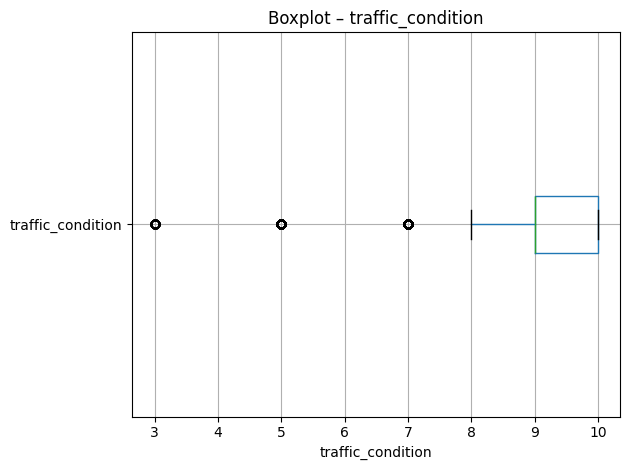

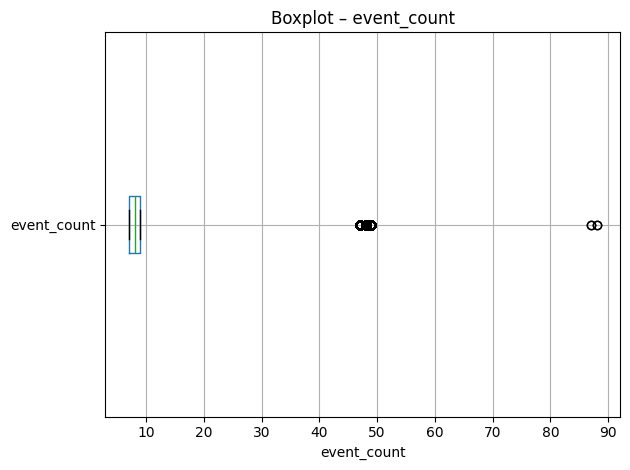

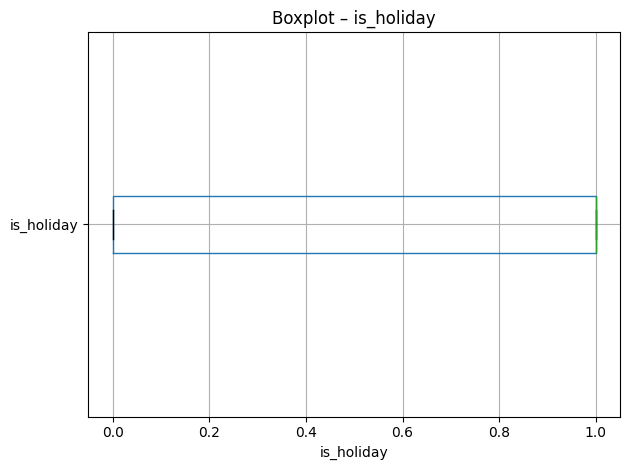

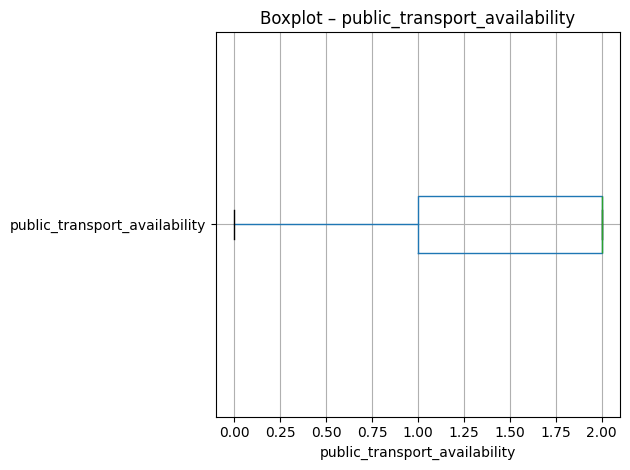

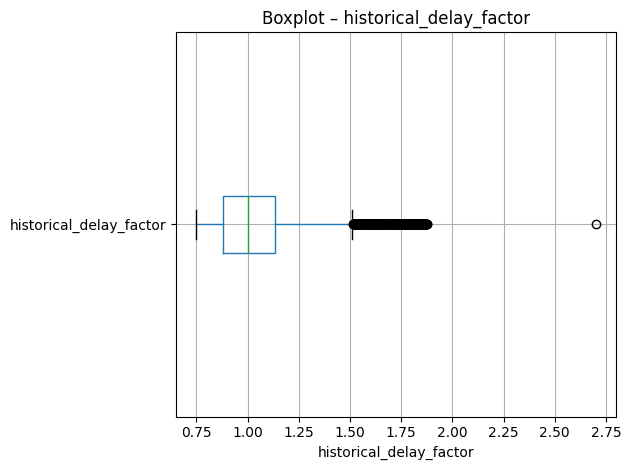

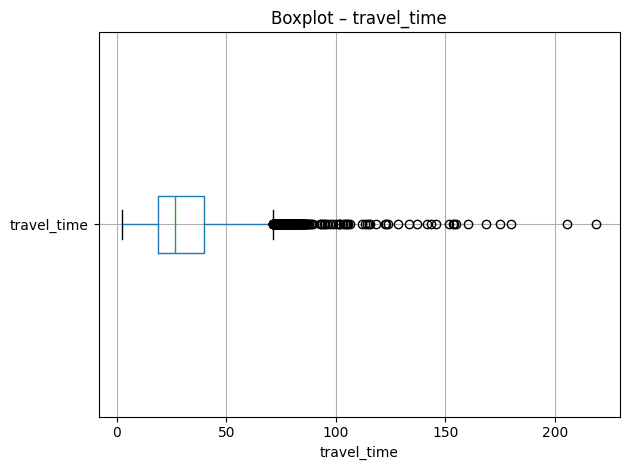

In [109]:
# Mengecek Outlier dengan boxplot
# Pilih hanya kolom numerik
num_cols = df.select_dtypes(include=[np.number]).columns

# Buat satu figure per kolom
for col in num_cols:
    plt.figure()                      
    df.boxplot(column=col, vert=False)  
    plt.title(f'Boxplot – {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

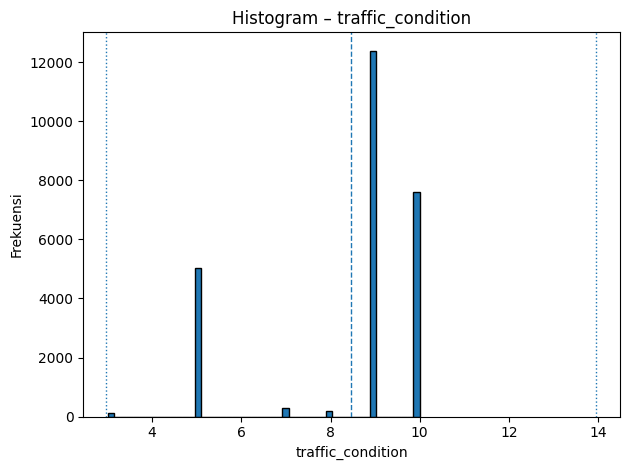

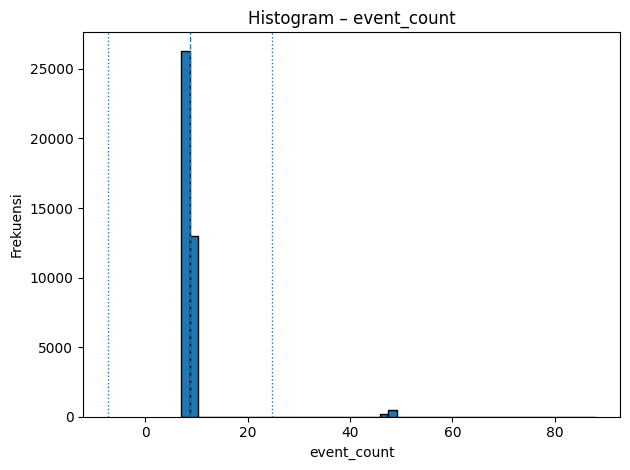

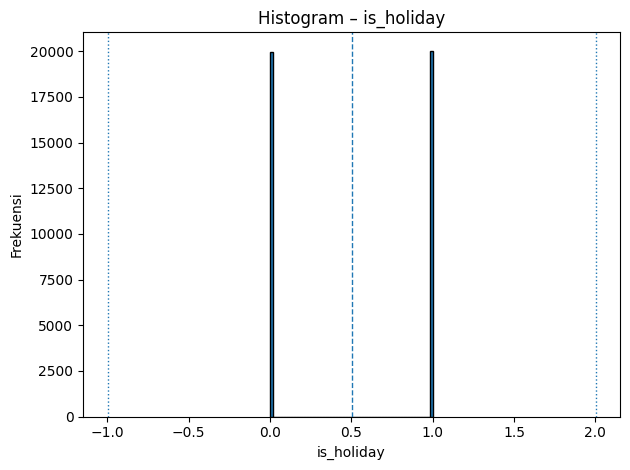

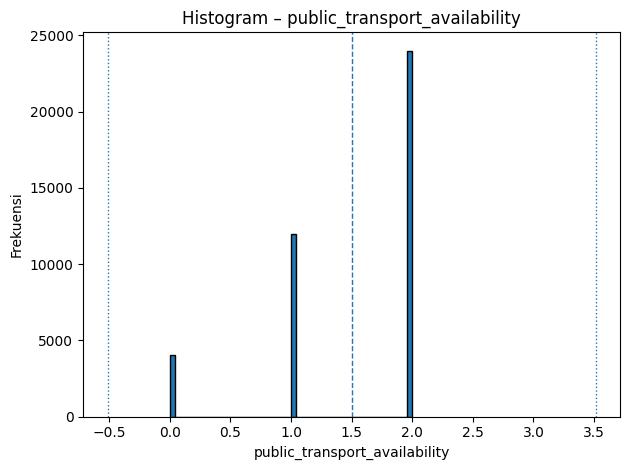

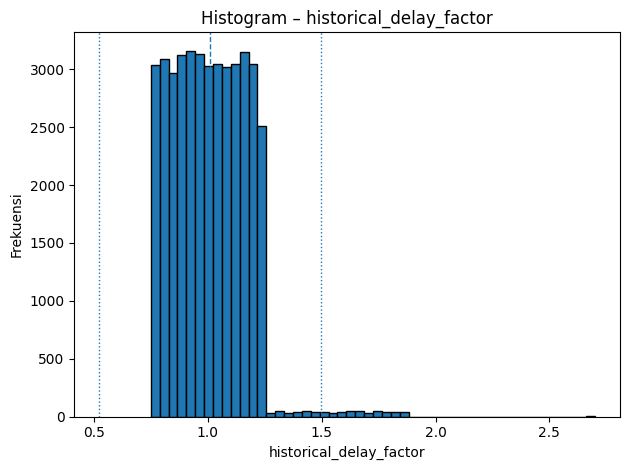

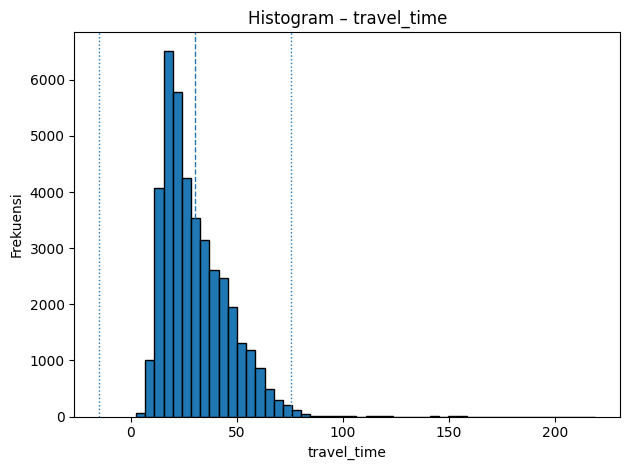

In [110]:
# melihat outlier dari histogram
num_cols = df.select_dtypes(include=[np.number]).columns

#  Histogram per kolom 
for col in num_cols:
    plt.figure()                       
    
    plt.hist(
        df[col].dropna(),              
        bins=50,                       
        edgecolor='black'
    )
    
    mu  = df[col].mean()
    sig = df[col].std()
    plt.axvline(mu,          linestyle='--', linewidth=1)          # rata‑rata
    plt.axvline(mu + 3*sig,  linestyle=':', linewidth=1)           # +3σ
    plt.axvline(mu - 3*sig,  linestyle=':', linewidth=1)           # −3σ
    
    plt.title(f'Histogram – {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()

In [111]:
# melihat data outlier pada kolom historical_delay_faktor
outliers = df[df['historical_delay_factor'] > 2.5]
outliers 

,start_point,end_point,time_of_day,day_of_week,traffic_condition,event_count,is_holiday,vehicle_density,population_density,weather,public_transport_availability,historical_delay_factor,travel_time
1601,Central Jakarta (Jakarta Pusat),West Jakarta (Jakarta Barat),day,Saturday,9.0,7,0,high,low,NaN,2,2.70101,47.343081


In [112]:
df[df['event_count'] > 80]

,start_point,end_point,time_of_day,day_of_week,traffic_condition,event_count,is_holiday,vehicle_density,population_density,weather,public_transport_availability,historical_delay_factor,travel_time
18210,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),day,Thursday,NaN,87,1,low,NaN,NaN,1,1.725496,31.843351
18707,North Jakarta (Jakarta Utara),South Jakarta (Jakarta Selatan),day,Wednesday,5.0,88,0,low,medium,fog,1,1.047474,39.196557
23318,North Jakarta (Jakarta Utara),South Jakarta (Jakarta Selatan),night,Saturday,9.0,88,0,low,medium,rain,1,0.926630,33.051378
32877,South Jakarta (Jakarta Selatan),East Jakarta (Jakarta Timur),evening,Wednesday,NaN,87,0,medium,NaN,fog,2,0.792486,17.544563


Catatan :
Dari pengecekan outlier, terdapat beberapa nilai yang cukup terpencil, tetapi masing masing nilai memang menunjukkan variasi dari data tersebut bukan akibat kesalahan input sehingga data tersebut tidak di drop

## Dataset Splitting

In [ ]:
# Splitting dataset (80% train, 20% test)
X = df.drop(columns=['travel_time'])
y = df['travel_time']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)
X_train.shape, X_test.shape

((32000, 12), (8000, 12))

### Pipeline cleansing dan preprocessing


In [114]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder

In [115]:
# pipeline preprocessing untuk kolom numeric
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='median')),
    ("scale", RobustScaler()),
])
numeric_pipeline

,steps,"[('impute', ...), ('scale', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,with_centering,True


In [116]:
# pipeline preprocessing untuk kolom kategorik
categoric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='most_frequent')),
    ("encode", OneHotEncoder(drop="first", handle_unknown="ignore"))
])
categoric_pipeline

,steps,"[('impute', ...), ('encode', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [117]:
# menampilkan kolom numerik
numeric_cols = df.select_dtypes(include=[np.number]).columns
# menampilkan kolom kategorik
categoric_cols = df.select_dtypes(exclude=[np.number]).columns
print("Kolom Numerik:", numeric_cols)
print("Kolom Kategorik:", categoric_cols)

Kolom Numerik: Index(['traffic_condition', 'event_count', 'is_holiday',
       'public_transport_availability', 'historical_delay_factor',
       'travel_time'],
      dtype='object')
Kolom Kategorik: Index(['start_point', 'end_point', 'time_of_day', 'day_of_week',
       'vehicle_density', 'population_density', 'weather'],
      dtype='object')


In [118]:
# menggabungkan pipeline preprocessing untuk kolom numerik dan kategorik
preprocessor = ColumnTransformer([
    ("numeric", numeric_pipeline, ['traffic_condition', 'event_count', 'is_holiday',
       'public_transport_availability', 'historical_delay_factor']),
    ("categoric", categoric_pipeline, ['start_point', 'end_point', 'time_of_day', 'day_of_week',
       'vehicle_density', 'population_density', 'weather'])
])
preprocessor

,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## Trainning

### Pipeline Modeling + preprocessing

In [119]:
from sklearn.linear_model import Ridge,LinearRegression, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import GridSearchCV

In [120]:
# Linear Regression
pipe_lin = Pipeline([
    ("prep", preprocessor),
    ("algo", LinearRegression())
])
pipe_lin.fit(X_train, y_train)

,steps,"[('prep', ...), ('algo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [121]:
# Ridge Regression Pipeline
pipeline_Ridge = Pipeline([
    ("prep", preprocessor),
    ("algo", Ridge())
])
param_grid_ridge = {
    "algo__alpha": [0.01, 0.1, 1, 10, 100],
    "algo__fit_intercept": [True, False]
}
modelRidge = GridSearchCV(pipeline_Ridge, param_grid_ridge, cv=5, n_jobs=-1, verbose=1)
modelRidge.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,"Pipeline(step...o', Ridge())])"
,param_grid,"{'algo__alpha': [0.01, 0.1, ...], 'algo__fit_intercept': [True, False]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric', ...), ('categoric', ...)]"


In [122]:
# Lasso Regression
pipe_lasso = Pipeline([
    ("prep", preprocessor),
    ("algo", Lasso(max_iter=5000))
])
param_lasso = {
    "algo__alpha": [0.0005, 0.001, 0.01, 0.1, 1],
    "algo__fit_intercept": [True, False]
}
gs_lasso = GridSearchCV(pipe_lasso, param_lasso, cv=5, n_jobs=-1, verbose=1)
gs_lasso.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step..._iter=5000))])
,param_grid,"{'algo__alpha': [0.0005, 0.001, ...], 'algo__fit_intercept': [True, False]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric', ...), ('categoric', ...)]"


In [123]:
# ElasticNet
pipe_elastic = Pipeline([
    ("prep", preprocessor),
    ("algo", ElasticNet(max_iter=5000))
])
param_elastic = {
    "algo__alpha": [0.0005, 0.001, 0.01, 0.1, 1],
    "algo__l1_ratio": [0.2, 0.5, 0.8],       # 0=l2(ridge), 1=l1(lasso)
    "algo__fit_intercept": [True, False]
}
gs_elastic = GridSearchCV(pipe_elastic, param_elastic, cv=5, n_jobs=-1, verbose=1)
gs_elastic.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,Pipeline(step..._iter=5000))])
,param_grid,"{'algo__alpha': [0.0005, 0.001, ...], 'algo__fit_intercept': [True, False], 'algo__l1_ratio': [0.2, 0.5, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric', ...), ('categoric', ...)]"


In [124]:
#  SGD Regression (stochastic gradient descent)
pipe_sgd = Pipeline([
    ("prep", preprocessor),
    ("algo", SGDRegressor(penalty='elasticnet', max_iter=2000, tol=1e-3))
])
param_sgd = {
    "algo__alpha": [1e-5, 1e-4, 1e-3],
    "algo__l1_ratio": [0.15, 0.5, 0.9],
    "algo__learning_rate": ["optimal", "adaptive", "invscaling"]
}
gs_sgd = GridSearchCV(pipe_sgd, param_sgd, cv=5, n_jobs=-1, verbose=1)
gs_sgd.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,Pipeline(step...lasticnet'))])
,param_grid,"{'algo__alpha': [1e-05, 0.0001, ...], 'algo__l1_ratio': [0.15, 0.5, ...], 'algo__learning_rate': ['optimal', 'adaptive', ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric', ...), ('categoric', ...)]"


## Evaluasi

### Perhitungan Metrik
- Hitung prediksi di masing-masing data train dan data test
- Hitung metrik R2

In [125]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [126]:
from sklearn.metrics import r2_score

#linear regression
y_pred_train_lin = pipe_lin.predict(X_train)
y_pred_test_lin  = pipe_lin.predict(X_test)
print("Linear Regression")
print("  R² train :", r2_score(y_train, y_pred_train_lin))
print("  R² test  :", r2_score(y_test,  y_pred_test_lin))
print()

# Ridge Regression
best_ridge = modelRidge.best_estimator_
y_pred_train_ridge = best_ridge.predict(X_train)
y_pred_test_ridge  = best_ridge.predict(X_test)
print("Ridge Regression (best)")
print("  R² train :", r2_score(y_train, y_pred_train_ridge))   
print("  R² test  :", r2_score(y_test,  y_pred_test_ridge))
print()


# Lasso (pakai estimator terbaik)
best_lasso = gs_lasso.best_estimator_
y_pred_train_lasso = best_lasso.predict(X_train)
y_pred_test_lasso  = best_lasso.predict(X_test)
print("Lasso (best)")
print("  R² train :", r2_score(y_train, y_pred_train_lasso))
print("  R² test  :", r2_score(y_test,  y_pred_test_lasso))
print()

#  ElasticNet
best_elastic = gs_elastic.best_estimator_
y_pred_train_elastic = best_elastic.predict(X_train)
y_pred_test_elastic  = best_elastic.predict(X_test)
print("ElasticNet (best)")
print("  R² train :", r2_score(y_train, y_pred_train_elastic))
print("  R² test  :", r2_score(y_test,  y_pred_test_elastic))
print()

# SGDRegressor
best_sgd = gs_sgd.best_estimator_
y_pred_train_sgd = best_sgd.predict(X_train)
y_pred_test_sgd  = best_sgd.predict(X_test)
print("SGDRegressor (best)")
print("  R² train :", r2_score(y_train, y_pred_train_sgd))
print("  R² test  :", r2_score(y_test,  y_pred_test_sgd))
print()


Linear Regression
  R² train : 0.8800310551314626
  R² test  : 0.8897269933133266

Ridge Regression (best)
  R² train : 0.8800309235795685
  R² test  : 0.8897299097657484

Lasso (best)
  R² train : 0.8800304733023719
  R² test  : 0.8897359810605739

ElasticNet (best)
  R² train : 0.8800282593666927
  R² test  : 0.8897415601519478

SGDRegressor (best)
  R² train : 0.8800309180770363
  R² test  : 0.8897248012936423



Catatan : 
1. Menggunakan model SGD Regressor dengan mendapat nilai yang tinggi di file submission

### Actual vs Prediction Plot

In [137]:
from sklearn.metrics import PredictionErrorDisplay

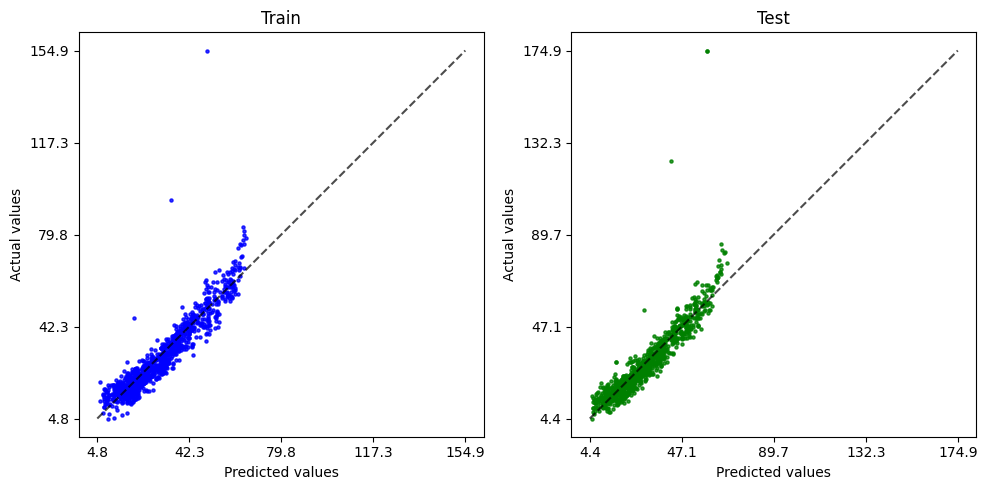

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
PredictionErrorDisplay.from_estimator(best_sgd, X_train, y_train, kind="actual_vs_predicted", scatter_kwargs={"c": "b", "s": 5}, ax=ax[0])
ax[0].set_title("Train")
ax[0].set_aspect("equal")

PredictionErrorDisplay.from_estimator(best_sgd, X_test, y_test, kind="actual_vs_predicted", scatter_kwargs={"c": "g", "s": 5}, ax=ax[1])
ax[1].set_title("Test")
ax[1].set_aspect("equal")

fig.tight_layout()

# Submit Prediksimu ke LMS

In [134]:
df_submit = pd.read_csv("test_sample.csv")

In [136]:
pd.DataFrame( best_sgd.predict(df_submit)).to_csv('my_submission.csv')